In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, P_BFGS
from qiskit_algorithms.utils import algorithm_globals
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 42

In [2]:
def ans(n, depth):
    qc = QuantumCircuit(n)
    for j in range(depth):
        for i in range(n):
            param_name = f'theta_{j}_{i}'
            theta_param = Parameter(param_name)
            qc.rx(theta_param, i)
            qc.ry(theta_param, i)
            qc.rz(theta_param, i)
    for i in range(n):
        if i == n-1:
            qc.cx(i, 0)
        else:
            qc.cx(i, i+1)
    return qc

In [3]:
num_features = 2
df = pd.read_csv('./data/Apple stock.csv')

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [5]:
# set index as date
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

In [6]:
mid_prices = (df['High'] + df['Low'])/2

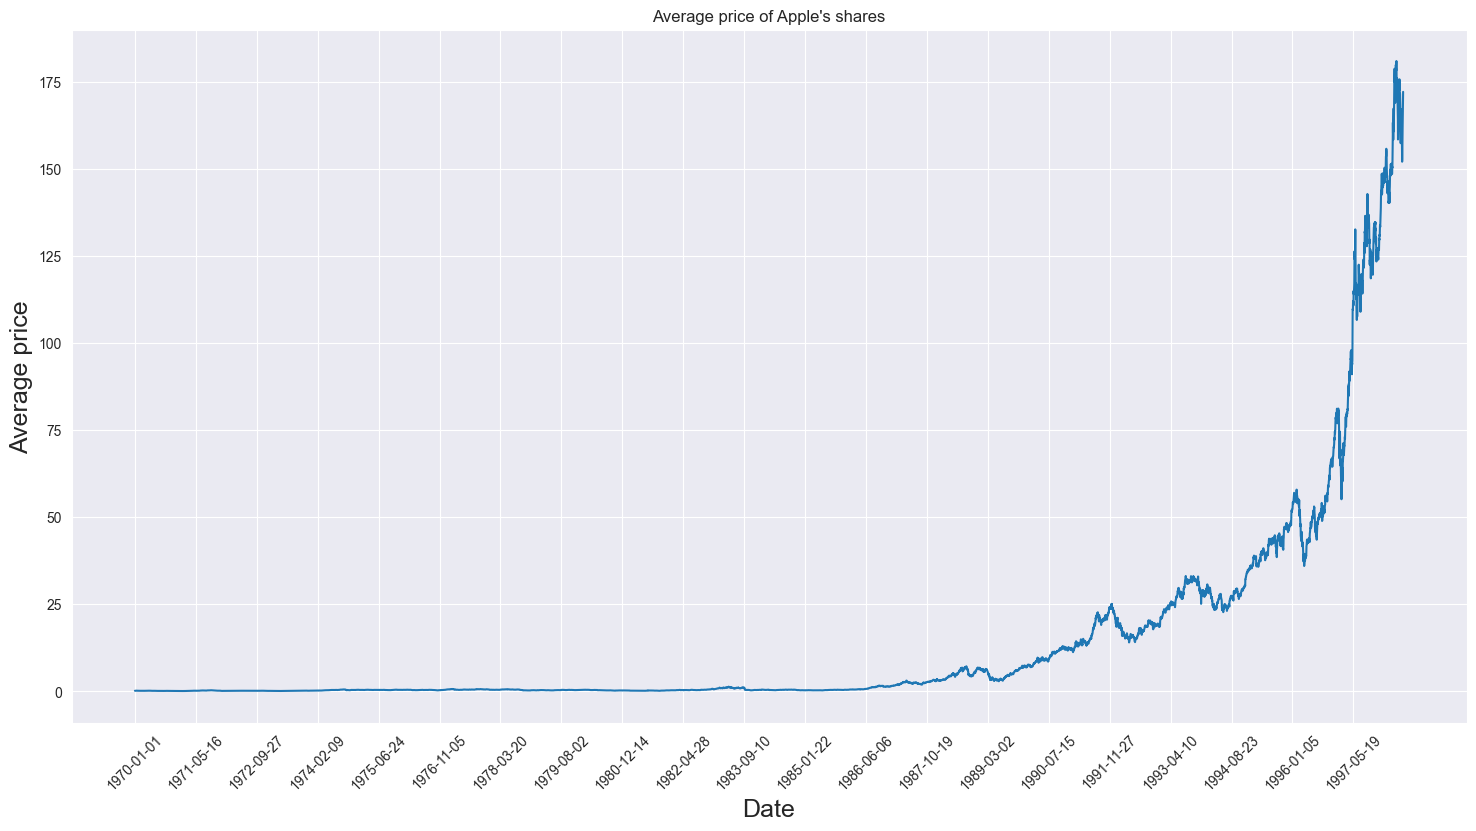

In [7]:
from matplotlib.dates import DateFormatter

formatter = DateFormatter('%Y-%m-%d')

plt.figure(figsize = (18, 9))
plt.plot(range(df.shape[0]), mid_prices)
plt.xticks(range(0, df.shape[0], 500), df['Date'].loc[::500], rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Average price', fontsize=18)
plt.title('Average price of Apple\'s shares')

# Apply time format 
plt.gcf().axes[0].xaxis.set_major_formatter(formatter)

plt.show()

In [8]:
df = df[['Open', 'Date']]
input_sequences = []
labels = []

#Creating input and output data for time series forecasting
for i in range(len(df['Open'])):
    if i > 1:
        labels.append(df['Open'].iloc[i])
        input_sequences.append(df['Open'].iloc[i-2:i])

print(len(input_sequences))

# sc_is = MinMaxScaler(feature_range = (0, 1))
# sc_ls = MinMaxScaler(feature_range = (0, 1))
# input_sequences = sc_is.fit_transform(input_sequences)
# labels = sc_ls.fit_transform(np.array(labels).reshape(-1, 1))


x_train = np.array(input_sequences[0:500])
x_test = np.array(input_sequences[500:600])
y_train = np.array(labels[0:500])
y_test = np.array(labels[500:600])

10407


In [9]:
from qiskit_algorithms.optimizers import ADAM
from qiskit.circuit.library import PauliFeatureMap

num_features =  2
feature_map = PauliFeatureMap(feature_dimension = num_features, reps = 2)
optimizer = ADAM(maxiter = 100)

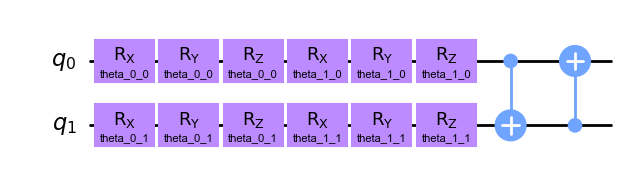

In [10]:
ansatz = ans(num_features, 2)
ansatz.draw('mpl', style='clifford')

In [11]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    print("Objective function evaluation #{} value: {}".format(len(objective_func_vals), obj_func_eval))
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

Objective function evaluation #0 value: 0.12706809125631482


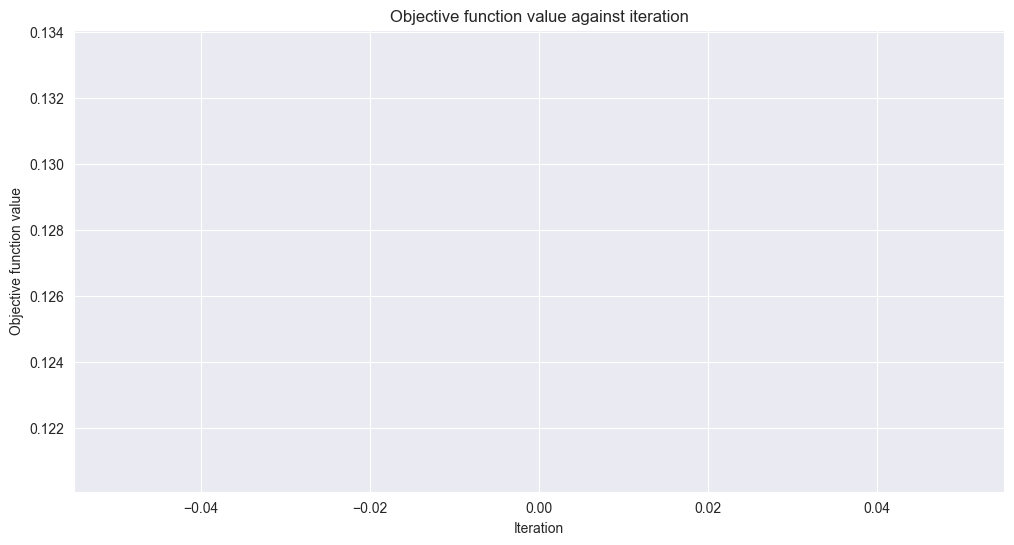

In [12]:
vqr = VQR(feature_map=feature_map,
          ansatz=ansatz,
          optimizer=optimizer,
          callback=callback_graph)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(x_train, y_train)
# regressor.fit(train_features, train_labels)
# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

In [13]:
from sklearn.metrics import mean_squared_error

vqr_mse = mean_squared_error(y_test, vqr.predict(x_test))

# Calculate root mean squared error
vqr_rmse = np.sqrt(vqr_mse)
print("Root Mean Squared Error VQR: ", vqr_rmse)

Root Mean Squared Error VQR:  0.43264423975359867
